# Emergency Path Planning in radiation world Based on the Deep Q-Learning (DQL)

Authors:

- Khalid OUBLAL: khalid.oublal@polytechnique.edu
- Xinyi DAI: xinyi.dai@polytechnique.edu
- Yutong Meng: yutong.meng@polytechnique.edu

(Affiliation): dept. Computer Science, E ́COLE POLYTECHNIQUE- IP PARIS, France 

Machine learning is a subset of AI that uses artificial neural networks. This particular project uses a deep reinforcement learning approach with two neural networks. Reinforcement learning uses the Markov decision process which involves states, actions, and rewards. For example, the NNs make predictions based on past actions in similar game states which granted specific rewards. After processing the environment, the NNs output the Q-value of all possible actions and decide which action grants the highest reward. After executing the chosen action, the NNs update its model weights to remember and improve.

Opposed to Q-learning, deep Q-learning NNs do not store all the possible actions and states in a Q-table. Instead, it uses an approximation function to generalize Q-values, which results in a machine learning approach suited to more complex environments with more possible actions.

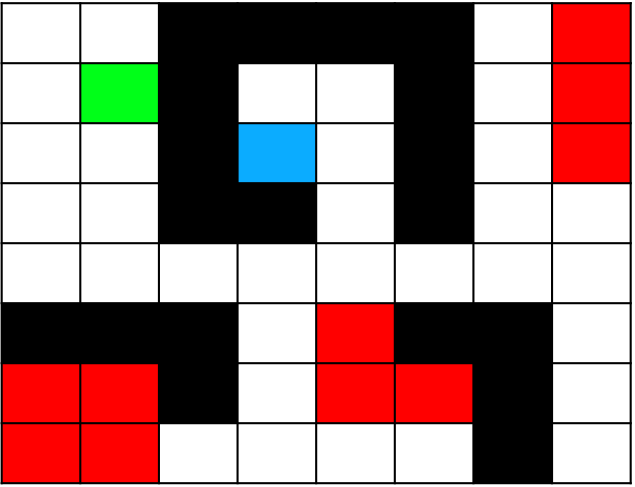

- Red grid: Areas with radiation
- Green grid: The base station for the Robot
- Blue grid: Indicates grid cells containing humans Human waiting for rescue
- Black grid: Walls
- White grid: Path




In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Reward

In [72]:
import sys

class Reward:

    rewardValue = 0.0
    pseudoRewardValue = 0.0
    def __init__(self, value=None):
        if value != None:
            self.rewardValue = value

# Observation

In [73]:
class Observation:
    worldState = []
    availableActions = []
    hierarchy = {}
    isTerminal = None
    def __init__(self, state=None, actions=None, hierarchy=None, isTerminal=None):
        if state != None:
            self.worldState = state

        if actions != None:
            self.availableActions = actions

        if hierarchy != None:
            self.hierarchy = hierarchy

        if isTerminal != None:
            self.isTerminal = isTerminal

# Action

In [74]:
import sys
class Action:
    actionValue = -1

    def __init__(self, value=None):
        if value != None:
            self.actionValue = value

# Environment

In [75]:
import random
import copy
import sys
import numbers



class Environment:

    # Survivors have unique IDs.
    smallestSurvivorID = 6 # Cannot be smaller than 5
    largestSurvivorID = 9 # Cannot be larger than 9
    
    # The grid world
    # 1 = walls
    # 2 = radiation
    # 4 = goal (non-terminal)
    # 5 = goal (terminal)
    # 6-9 = people to rescue
    map = [[1, 1, 1, 1, 1, 1, 1],
           [1, 0, 2, 6, 1, 7, 1],
           [1, 0, 2, 0, 2, 0, 1],
           [1, 0, 0, 4, 2, 0, 1],
           [1, 1, 1, 1, 1, 1, 1]]
    # Note: the extremities of the map should be '1's.
    # Width and height should match the actual dimensions of the grid above
    width = 7
    height = 5
    
    # Which direction should the enemy walk?
    # 0 = up
    # 1 = down
    # 2 = left
    # 3 = right
    influenceMap = [[3, 1, 1, 1, 1, 1, 2],
                    [3, 1, 2, 2, 2, 1, 2],
                    [3, 1, 0, 0, 2, 2, 2],
                    [3, 3, 3, 0, 2, 2, 2],
                    [3, 0, 0, 0, 0, 0, 2]]
  
    # The current state
    currentState = []

    # The previous state
    previousState = []
    
    # Hard-coded initial state (used unless randomStart = True)
    # 0: bot x
    # 1: bot y
    # 2: enemy alive?
    # 3: enemy x
    # 4: enemy y
    # 5: enemy torture mode?
    # 6-9: person rescue state (if any)
    startState = [1, 1, True, 3, 1, False, False, False]
    
    # Amount of reward at the goal
    reward = 10.0
    
    # Amount of reward for each rescue
    rescue = 20.0
    
    # Amount of penalty
    penalty = -1.0
    
    # Amount of penalty from touching the enemy
    pain = -50.0
    
    # amount of penalty from touching radiation
    radiation = -20.0
    
    # Amount of penalty from dead enemy
    enemyDead = -10.0
    
    # Incremented every step
    counter = 0
    
    # enemy move timer
    moveTimer = 1
    
    # how should the enemy move?
    # 0: doesn't move
    # 1: uses influence map
    # 2: moves randomly
    # 3: chases the bot
    # 4: gets input from external source
    enemyMode = 1
    
    # if enemyMode = 4
    nextEnemyMove = None
    
    # Randomly generate a start state
    randomStart = False
    
    randGenerator=random.Random()
    lastActionValue = -1

    # Print debuggin information
    verbose = False

    # 0 = up
    # 1 = down
    # 2 = left
    # 3 = right
    # 4 = smash
    def validActions(self):
        resultArray = [0, 1, 2, 3, 4]
        return resultArray
    
    # Get the name of the action
    def actionToString(self, act):
        if act == 0:
            return "GoUp"
        elif act == 1:
            return "GoDown"
        elif act == 2:
            return "GoLeft"
        elif act == 3:
            return "GoRight"
        elif act == 4:
            return "Smash"
        return str(act)


    # Called to start the simulation
    def env_start(self):
        # Use hard-coded start state or randomly generated state?
        if self.randomStart:
            self.currentState = self.randomizeStart(self.map)
        else:
            self.currentState = self.startState[:]

        # Make sure counter is reset
        self.counter = 0

        if self.isVerbose():
            print("env_start", self.currentState)

        # Reset previous state
        self.previousState = []

        # Get the first observation
        returnObs=Observation()
        returnObs.worldState=self.currentState[:]
        returnObs.availableActions = self.validActions()
        return returnObs

    # This creates a random initial state
    # Agent and enemy will not be placed on a wall
    def randomizeStart(self, map):
        bot = []
        enemy = []
        while True:
            bot = [random.randint(1,self.width-2), random.randint(1,self.height-2)]
            if map[bot[1]][bot[0]] != 1:
                break
        while True:
            enemy = [random.randint(1,self.width-2), random.randint(1,self.height-2)]
            if map[enemy[1]][enemy[0]] != 1:
                break
        state = bot + [True] + enemy + [False]
        for x in map:
            for xy in x:
                if xy >= self.smallestSurvivorID and xy <= self.largestSurvivorID:
                    state.append(False)
        return state

    # Update world state based on agent's action
    # Enemy is part of the world and autonomous from the agent
    def env_step(self,thisAction):
        # Store previous state
        self.previousState = self.currentState[:]
        # Execute the action
        self.executeAction(thisAction.actionValue)
                
        # increment counter
        self.counter = self.counter + 1
        
        # Enemy movement
        if self.currentState[2]:
            if self.currentState[0] == self.currentState[3] and self.currentState[1] == self.currentState[4]:
                self.currentState[5] = True
            else:
                self.currentState[5] = False
            if self.counter % self.moveTimer == 0:
                # Which direction to move?
                move = None
                if self.enemyMode == 1:
                    move = self.influenceMap[self.currentState[4]][self.currentState[3]]
                elif self.enemyMode == 2:
                    move = random.randint(0, 3)
                elif self.enemyMode == 3:
                    move = self.chaseDirection((self.currentState[3], self.currentState[4]), (self.currentState[0], self.currentState[1]))
                elif self.enemyMode == 4 and self.nextEnemyMove is not None:
                    move = self.nextEnemyMove
                if self.isVerbose():
                    print("enemy action:", self.actionToString(move))
                if move is not None:
                    # newpos will be the new grid cell the enemy moves into
                    newpos = [self.currentState[3], self.currentState[4]]
                    if move == 0:
                        newpos[1] = newpos[1] - 1
                    elif move == 1:
                        newpos[1] = newpos[1] + 1
                    elif move == 2:
                        newpos[0] = newpos[0] - 1
                    elif move == 3:
                        newpos[0] = newpos[0] + 1
                    
                    # Make sure it can't move into a wall
                    if self.map[newpos[1]][newpos[0]] == 1:
                        newpos[0] = self.currentState[3]
                        newpos[1] = self.currentState[4]


                    # update state
                    self.currentState[3] = newpos[0]
                    self.currentState[4] = newpos[1]
    
        # Rescuing
        # People can be given numbers 5-9 and their rescue state is in positions 5-9 of the bot's state
        for i in range(min(len(self.startState), self.largestSurvivorID) - self.smallestSurvivorID):
            survivor = i + self.smallestSurvivorID
            if not self.currentState[survivor] and self.map[self.currentState[1]][self.currentState[0]] == survivor:
                self.currentState[survivor] = True

        if self.isVerbose():
            print("state:", self.currentState)
            if isinstance(self.verbose, numbers.Number) and self.verbose >= 2:
                self.printEnvironment()

        # Make a new observation
        lastActionValue = thisAction.actionValue
        theObs=Observation()
        theObs.worldState=self.currentState[:]
        theObs.availableActions = self.validActions()
        theObs.isTerminal = self.checkTerminal()

        # Calculate the reward
        rewardValue = self.calculateReward(lastActionValue)
        reward = Reward(rewardValue)

        return theObs, reward

        
    # reset the environment
    def env_reset(self):
        # use random start or hard-coded start state?
        if self.randomStart:
            self.currentState = self.randomizeStart(self.map)
        else:
            self.currentState = self.startState[:]
        
        # reset the counter
        self.counter = 0


    # Is agent in a terminal state?
    def checkTerminal(self):
        if self.map[self.currentState[1]][self.currentState[0]] == 5:
            return True
        else:
            return False

    # Agent executes an action, update the state
    def executeAction(self, theAction):
        newpos = [self.currentState[0], self.currentState[1]]
        if (theAction == 0):#Move Up
            if self.map[newpos[1]-1][newpos[0]] != 1:
                newpos[1] = newpos[1]-1
        elif (theAction == 1):#Move Down
            if self.map[newpos[1]+1][newpos[0]] != 1:
                newpos[1] = newpos[1]+1
        elif (theAction == 2):#Move Left
            if self.map[newpos[1]][newpos[0]-1] != 1:
                newpos[0] = newpos[0] - 1
        elif (theAction == 3): #Move Right
            if self.map[newpos[1]][newpos[0]+1] != 1:
                newpos[0] = newpos[0] + 1
        elif (theAction == 4): #smash
            if self.currentState[0] == self.currentState[3] and self. currentState[1] == self.currentState[4]:
                # Smashing the enemy
                self.currentState[2] = False
        self.currentState[0] = newpos[0]
        self.currentState[1] = newpos[1]
        

    # What reward should the agent get?
    def calculateReward(self, theAction):
        r = 0
        if self.currentState[2] and self.currentState[5]:
            # enemy is alive and co-located with the bot for more than one turn
            r = r + self.pain
        elif not self.currentState[2]:
            # enemy is dead
            r = r + self.enemyDead
        
        # Survivors can be given numbers 6-9 and their rescue state is in positions 6-9 of the bot's state
        for i in range(min(self.largestSurvivorID, len(self.currentState)) - self.smallestSurvivorID):
            survivor = i + self.smallestSurvivorID
            if self.currentState[survivor]:
                r = r + self.rescue

        
        if self.map[self.currentState[1]][self.currentState[0]] == 5:
            r = r + self.reward
        elif self.map[self.currentState[1]][self.currentState[0]] == 4:
            r = r + self.reward
        elif self.map[self.currentState[1]][self.currentState[0]] == 2:
            r = r + self.radiation
        else:
            r = r + self.penalty
        return r

    ### print the map
    ### key:
    # 1 = walls
    # 2 = radiation
    # 4 = goal (non-terminal)
    # 5 = goal (terminal)
    # 6-9 = people to rescue
    # A = agent
    # E = enemy
    # O = agent and enemy are co-located
    # Q = agent and enemy are co-located and enemy torturing agent
    # X = enemy is dead
    def printEnvironment(self):
        for j in range(self.height):
            p = ""
            for i in range(self.width):
                q = ""
                if self.currentState[0] == i and self.currentState[1] == j and self.currentState[3] == i and self.currentState[4] == j and self.currentState[2]:
                    # Both co-located and enemy alive
                    if not self.currentState[5]:
                        # enemy not in torture mode
                        q = "O"
                    else:
                        # enemy in torture mode
                        q = "Q"
                elif self.currentState[0] == i and self.currentState[1] == j:
                    # not co-located, bot here
                    q = "A"
                elif self.currentState[3] == i and self.currentState[4] == j:
                    # not co-located, enemy here
                    if self.currentState[2]:
                        q = "E"
                    else:
                        q = "X"
                else:
                    q = str(self.map[j][i])
                    num = self.map[j][i]
                    if num > 5 and len(self.currentState) >= num+1 and self.currentState[num]:
                        # There is a human here, but that person has been saved
                        q = '0'
                p = p + q + " "
            print(p)

    def isVerbose(self):
        if isinstance(self.verbose, numbers.Number) and self.verbose == 0:
            return False
        return self.verbose

    def chaseDirection(self, myPos, targetPos):
        if targetPos[0] > myPos[0]:
            return 3 # go right
        elif targetPos[0] < myPos[0]:
            return 2 # go left
        elif targetPos[1] < myPos[1]:
            return 0 # go up
        else:
            return 1 # go down

# Agent

In [76]:
import random
import sys
import copy
import operator
from random import Random

class Agent:
    # Random generator
    randGenerator=Random()

    # Remember last action
    lastAction=Action()

    # Remember last observation (state)
    lastObservation=Observation()
    
    # Q-learning stuff: Step size, epsilon, gamma, learning rate
    epsilon = 0.5
    gamma = 0.9
    learningRate = 0.5

    # Value table
    v_table = None

    # The environment
    gridEnvironment = None
    
    #Initial observation
    initialObs = None
    
    #Current observation
    currentObs = None
    
    # The training or testing episdoe will run for no more than this many time steps
    numSteps = 500
    
    # Total reward
    totalReward = 0.0
    
    # Print debugging statements
    verbose = True
    
    # Number of actions in the environment
    numActions = 5

    # Constructor, takes a reference to an Environment
    def __init__(self, env):

        # Initialize value table
        self.v_table={}
        
        # Set dummy action and observation
        self.lastAction=Action()
        self.lastObservation=Observation()
        
        # Set the environment
        self.gridEnvironment = env
        
        # Get first observation and start the environment
        self.initialObs = self.gridEnvironment.env_start()
        self.initializeVtableStateEntry(self.initialObs.worldState)
    
    # Make an empty row in the v table with the state as key.
    def initializeVtableStateEntry(self, state):
        if self.calculateFlatState(state) not in self.v_table.keys():
            self.v_table[self.calculateFlatState(state)] = self.numActions*[0.0]
    # Once learning is done, use this to run the agent
    # observation is the initial observation
    def executePolicy(self, observation):
        # History stores up list of actions executed
        history = []
        # Start the counter
        count = 0
        # reset total reward
        self.totalReward = 0.0
        # Copy the initial observation
        self.workingObservation = self.copyObservation(observation)
        
        # Make sure the value table has the starting observation
        self.initializeVtableStateEntry(self.workingObservation.worldState)

        if self.isVerbose():
            print("START")
        
        # While a terminal state has not been hit and the counter hasn't expired, take the best action for the current state
        while not self.workingObservation.isTerminal and count < self.numSteps:
            newAction = Action()
            # Get the best action for this state
            newAction.actionValue = self.greedy(self.workingObservation)
            history.append((newAction.actionValue, self.workingObservation.worldState))

            if self.isVerbose():
                print("state:", self.workingObservation.worldState)
                print( "bot action:", self.gridEnvironment.actionToString(newAction.actionValue))

            # execute the step and get a new observation and reward
            currentObs, reward = self.gridEnvironment.env_step(newAction)
            if self.isVerbose():
                print("reward:", reward.rewardValue)

            
            self.totalReward = self.totalReward + reward.rewardValue
            self.workingObservation = copy.deepcopy(currentObs)

            # increment counter
            count = count + 1
        if self.isVerbose():
            print("END")
        return history
    

    # Q-learning implementation
    # observation is the initial observation
    def qLearn(self, observation):
        # copy the initial observation
        self.workingObservation = self.copyObservation(observation)
        
        # start the counter
        count = 0

        lastAction = -1
        
        # reset total reward
        self.totalReward = 0.0
        
        # while terminal state not reached and counter hasn't expired, use epsilon-greedy search
        while not self.workingObservation.isTerminal and count < self.numSteps:
            
            # Make sure table is populated correctly
            self.initializeVtableStateEntry(self.workingObservation.worldState)

            # Take the epsilon-greedy action
            newAction = Action()
            newAction.actionValue = self.egreedy(self.workingObservation)
            lastAction = newAction.actionValue

            # Get the new state and reward from the environment
            currentObs, reward = self.gridEnvironment.env_step(newAction)
            rewardValue = reward.rewardValue
            
            # Make sure table is populated correctly
            self.initializeVtableStateEntry(currentObs.worldState)

            # update the value table
            lastFlatState = self.calculateFlatState(self.workingObservation.worldState)
            newFlatState = self.calculateFlatState(currentObs.worldState)
            self.updateVtable(newFlatState, lastFlatState, newAction.actionValue, rewardValue, currentObs.isTerminal, currentObs.availableActions)
            
            # increment counter
            count = count + 1
            self.workingObservation = self.copyObservation(currentObs)
        
            # increment total reward
            self.totalReward = self.totalReward + reward.rewardValue


        # Done learning, reset environment
        self.gridEnvironment.env_reset()

    

    

    def updateVtable(self, newState, lastState, action, reward, terminal, availableActions):
        if terminal:
            self.v_table[lastState][action] += self.learningRate * (reward - self.v_table[lastState][action])
        maxvalue=-sys.maxsize
        for x in availableActions:
            if self.v_table[tuple(newState)][x]>maxvalue:
                maxvalue=self.v_table[tuple(newState)][x]
        self.v_table[lastState][action]+=self.learningRate*(reward+self.gamma*maxvalue-self.v_table[lastState][action])
        return None


    ### Return the best action according to the policy, or a random action epsilon percent of the time.
    ### observation: the current observation (state)
    ###
    ### If a random number between [0, 1] is less than epsilon, pick a random action from available actions.
    ### Otherwise: pick the action for the current state that has the highest Q value.
    ### Return the index of the action picked.
    def egreedy(self, observation):
        ran=random.uniform(0,1)
        i=-1
        #print "rand:", ran
        if ran<self.epsilon:
            i=random.randint(0,len(observation.availableActions)-1)
            #print "smaller"
        else:
            i=self.greedy(observation)
        #print "selected action:", i
        # YOUR CODE GOES ABOVE HERE
        return i

    ### Return the best action according to the policy
    ### observation: the current observation (state)
    ###
    ### Pick the action for the current state that has the highest Q value.
    ### Return the index of the action picked.
    def greedy(self, observation):
        self.initializeVtableStateEntry(observation.worldState)
        actions=self.v_table[tuple(observation.worldState)]
        maxvalue=-sys.maxsize
        bestactionlist=[]
        for i in range(len(actions)):
            action_value=actions[i]
            if action_value>maxvalue:
                maxvalue=action_value
                bestactionlist=[i]
            elif action_value==maxvalue:
                bestactionlist.append(i)
        if len(bestactionlist)<=1:
            bestaction=bestactionlist[0]
        else:
            bestaction=bestactionlist[random.randint(0,len(bestactionlist)-1)]
        # YOUR CODE GOES ABOVE HERE
        return bestaction
    

    # Reset the agent
    def agent_reset(self):
        self.lastAction = Action()
        self.lastObservation = Observation()
        self.initialObs = self.gridEnvironment.env_start()

    # Create a copy of the observation
    def copyObservation(self, obs):
        returnObs =  Observation()
        if obs.worldState != None:
            returnObs.worldState = obs.worldState[:]
        if obs.availableActions != None:
            returnObs.availableActions = obs.availableActions[:]
        if obs.isTerminal != None:
            returnObs.isTerminal = obs.isTerminal
        return returnObs
    
    # Turn the state into a tuple for bookkeeping
    def calculateFlatState(self, theState):
        return tuple(theState)

    def isVerbose(self):
        if isinstance(self.verbose, numbers.Number) and self.verbose == 0:
            return False
        return self.verbose

# SHOW

In [77]:
import sys
import numpy


# Training episodes
episodes = 800

# how often to report training results
trainingReportRate = 50

# play the interactive game?
# 0: human does not play
# 1: human plays as the bot
# 2: human plays as the enemy
play = 2

#Max reward received in any iteration
maxr = None

# Set up environment for initial training
gridEnvironment = Environment()
gridEnvironment.randomStart = False
gridEnvironment.enemyMode = 1
gridEnvironment.verbose = 0

# Set up agent
gridAgent = Agent(gridEnvironment)
gridAgent.verbose = False
gridAgent.epsilon=0.8

total_reward=[]
max_reward=[]
# This is where learning happens
for i in range(episodes):
    # Train
    gridAgent.agent_reset()
    gridAgent.qLearn(gridAgent.initialObs)
    # Test
    gridAgent.agent_reset()
    gridAgent.executePolicy(gridAgent.initialObs)
    # Report
    totalr = gridAgent.totalReward
    if maxr == None or totalr > maxr:
        maxr = totalr
    max_reward.append(maxr)
    total_reward.append(totalr)

In [ ]:
data = {'step': [k for k in range(len(max_reward))], 'max_reward': max_reward}
df=pd.DataFrame(data)
df.head(5)


,step,max_reward
0,0,10527.0
1,1,10527.0
2,2,10527.0
3,3,10527.0
4,4,10527.0


In [82]:
plt.rcdefaults()

Text(0, 0.5, 'Max Reward')

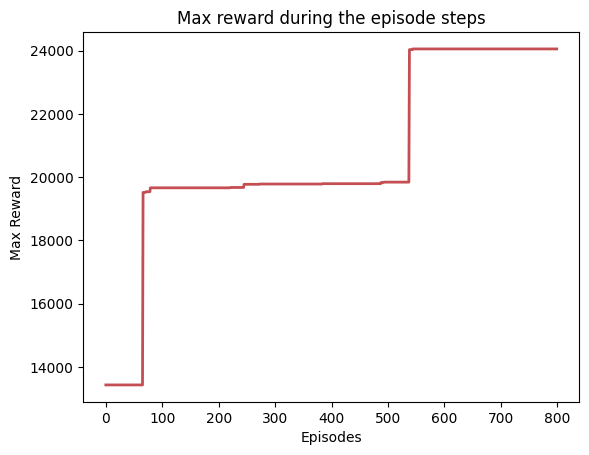

In [89]:
plt.plot(range(len(max_reward)),max_reward, 'r-', linewidth=2, markersize=12)
plt.title('Max reward during the episode steps')
plt.xlabel("Episodes")
plt.ylabel("Max Reward")

Text(0, 0.5, 'Total Reward')

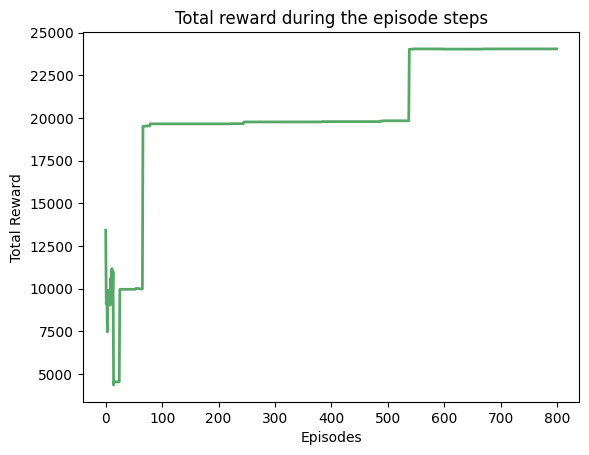

In [90]:
plt.plot(range(len(total_reward)),total_reward, 'g-', linewidth=2, markersize=12)
plt.title('Total reward during the episode steps')
plt.xlabel("Episodes")
plt.ylabel("Total Reward")

# Deep-Q-agent

In [96]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [97]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc0 = nn.Linear(34, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 5)

    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [101]:
Q_net=Net()

!pip install torchviz

from torchviz import make_dot

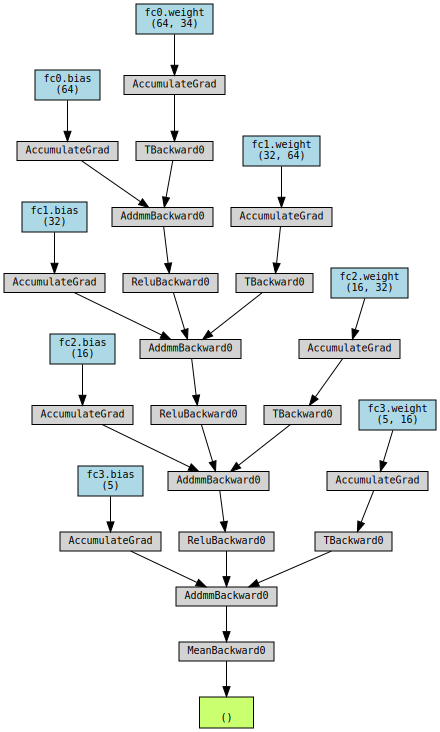

In [102]:
x = torch.randn(5, 34)
y = Q_net(x)

l=make_dot(y.mean(), params=dict(Q_net.named_parameters()), show_attrs=False, show_saved=False) 
l.render("attached", format="png")
l

In [104]:
from torchvision import models
from torchsummary import summary

In [105]:
import random
import sys
import copy
import operator
from random import Random

class Agent:
    # Random generator
    randGenerator=Random()

    # Remember last action
    lastAction=Action()

    # Remember last observation (state)
    lastObservation=Observation()
    
    # Q-learning stuff: Step size, epsilon, gamma, learning rate
    epsilon = 0.5
    gamma = 0.9
    learningRate = 0.5
    ''''''
    Q_net=Net()
    criterion=nn.MSELoss()
    optimizer = optim.Adam(Q_net.parameters(), lr=1e-1,weight_decay=1e-3)

    map=None
    # The environment
    gridEnvironment = None
    
    #Initial observation
    initialObs = None
    
    #Current observation
    currentObs = None
    
    # The training or testing episdoe will run for no more than this many time steps
    numSteps = 500
    
    # Total reward
    totalReward = 0.0
    
    # Print debugging statements
    verbose = True
    
    # Number of actions in the environment
    numActions = 5

    # Constructor, takes a reference to an Environment
    def __init__(self, env):

        
        # Set dummy action and observation
        self.lastAction=Action()
        self.lastObservation=Observation()
        
        # Set the environment
        self.gridEnvironment = env
        self.map=env.map
        
        # Get first observation and start the environment
        self.initialObs = self.gridEnvironment.env_start()
        
    def obs2vec(self,observation):
        input_vector=torch.zeros([34,1])
        #startState = [1, 1, True, 3, 1, False, False, False]
        s=observation.worldState
        input_vector[(s[0]-1)*5+s[1]-1]=  1
        input_vector[15+(s[3]-1)*5+s[4]-1]=  1
        input_vector[30] = s[2] 
        input_vector[31] = s[5]
        input_vector[32] = s[6]
        input_vector[33] = s[7]
        return input_vector

    def get_action(self,observation,action_value):
        s=observation.worldState
        max_action=Action()
        max_action_value=-10000
        
        for theAction in range(5):
            if (theAction == 0):#Move Up
                if self.map[s[1]-1][s[0]] != 1 and action_value[0,0]>max_action_value:
                    max_action.actionValue=0
                    max_action_value=action_value[0,0]
            elif (theAction == 1):#Move Down
                if self.map[s[1]+1][s[0]] != 1 and action_value[0,1]>max_action_value:
                    max_action.actionValue=1
                    max_action_value=action_value[0,1]
            elif (theAction == 2):#Move Left
                if self.map[s[1]][s[0]-1] != 1 and action_value[0,2]>max_action_value:
                    max_action.actionValue=2
                    max_action_value=action_value[0,2]
            elif (theAction == 3): #Move Right
                if self.map[s[1]][s[0]+1] != 1 and action_value[0,3]>max_action_value:
                    max_action.actionValue=3
                    max_action_value=action_value[0,3]
            elif (theAction == 4): #smash
                if s[0] == s[3] and s[1] == s[4] and action_value[0,4]>max_action_value:
                    max_action.actionValue=4
                    max_action_value=action_value[0,4]
        return max_action.actionValue, max_action_value
  
    

    # Once learning is done, use this to run the agent
    # observation is the initial observation
    def executePolicy(self, observation):
        # History stores up list of actions executed
        history = []
        # Start the counter
        count = 0
        # reset total reward
        self.totalReward = 0.0
        # Copy the initial observation
        self.workingObservation = self.copyObservation(observation)
        

        if self.isVerbose():
            print("START")
        
        # While a terminal state has not been hit and the counter hasn't expired, take the best action for the current state
        while not self.workingObservation.isTerminal and count < self.numSteps:
            newAction = Action()
            input_vec=self.obs2vec(self.workingObservation)
            #input_vec=Varia
            expect_rewards=self.Q_net(input_vec.T)

            # Get the best action for this state
            newAction.actionValue,_ = self.get_action(self.workingObservation,expect_rewards)
            history.append((newAction.actionValue, self.workingObservation.worldState))

            if self.isVerbose():
                print("state:", self.workingObservation.worldState)
                print( "bot action:", self.gridEnvironment.actionToString(newAction.actionValue))

            # execute the step and get a new observation and reward
            currentObs, reward = self.gridEnvironment.env_step(newAction)
            if self.isVerbose():
                print("reward:", reward.rewardValue)

            
            self.totalReward = self.totalReward + reward.rewardValue
            self.workingObservation = copy.deepcopy(currentObs)

            # increment counter
            count = count + 1
        if self.isVerbose():
            print("END")
        return history
    

    # Q-learning implementation
    # observation is the initial observation
    def deepqLearn(self, observation):
        # copy the initial observation
        self.workingObservation = self.copyObservation(observation)
        
        # start the counter
        count = 0

        lastAction = -1
        
        # reset total reward
        self.totalReward = 0.0
        
        # while terminal state not reached and counter hasn't expired, use epsilon-greedy search
        while not self.workingObservation.isTerminal and count < self.numSteps:

            # Take the epsilon-greedy action
            newAction = Action()
            input_vec=self.obs2vec(self.workingObservation)
            #input_vec=Varia
            expect_rewards=self.Q_net(input_vec.T)
            
            
            newAction.actionValue, max_expect_reward = self.get_action(self.workingObservation,expect_rewards)
            lastAction = newAction.actionValue

            # Get the new state and reward from the environment
            currentObs, reward = self.gridEnvironment.env_step(newAction)
            rewardValue = reward.rewardValue

   
            #self.updateQnet( currentObs, newAction.actionValue, expect_rewards, rewardValue, currentObs.isTerminal)
            self.optimizer.zero_grad()  
            target=expect_rewards.clone()
            _, max_action_value = self.get_action(currentObs,expect_rewards)
            
            
            target[0,newAction.actionValue]=reward.rewardValue+self.gamma*max_action_value
            #print(target,expect_rewards)
            loss=self.criterion(expect_rewards,target)

            loss.backward()
            #print(loss)
            self.optimizer.step() 
            # increment counter
            count = count + 1
            self.workingObservation = self.copyObservation(currentObs)
        
            # increment total reward
            self.totalReward = self.totalReward + reward.rewardValue


        # Done learning, reset environment
        self.gridEnvironment.env_reset()

    # Reset the agent
    def agent_reset(self):
        self.lastAction = Action()
        self.lastObservation = Observation()
        self.initialObs = self.gridEnvironment.env_start()

    # Create a copy of the observation
    def copyObservation(self, obs):
        returnObs =  Observation()
        if obs.worldState != None:
            returnObs.worldState = obs.worldState[:]
        if obs.availableActions != None:
            returnObs.availableActions = obs.availableActions[:]
        if obs.isTerminal != None:
            returnObs.isTerminal = obs.isTerminal
        return returnObs
    
    # Turn the state into a tuple for bookkeeping
    def calculateFlatState(self, theState):
        return tuple(theState)

    def isVerbose(self):
        if isinstance(self.verbose, numbers.Number) and self.verbose == 0:
            return False
        return self.verbose

In [110]:

import sys
import numpy
from tqdm.notebook import tqdm

# Training episodes
episodes = 800

# how often to report training results
trainingReportRate = 50

# play the interactive game?
# 0: human does not play
# 1: human plays as the bot
# 2: human plays as the enemy
play = 2

#Max reward received in any iteration
maxr = None

# Set up environment for initial training
gridEnvironment = Environment()
gridEnvironment.randomStart = False
gridEnvironment.enemyMode = 1
gridEnvironment.verbose = 0

# Set up agent
gridAgent = Agent(gridEnvironment)
gridAgent.verbose = False
gridAgent.epsilon=0.8

total_reward=[]
max_reward=[]
# This is where learning happens
for i in tqdm(range(episodes)):
    # Train
    
    gridAgent.agent_reset()
    gridAgent.deepqLearn(gridAgent.initialObs)
    print(list(gridAgent.Q_net.parameters())[0][0,0])
    # Test
    gridAgent.agent_reset()
    gridAgent.executePolicy(gridAgent.initialObs)
    # Report
    totalr = gridAgent.totalReward
    if maxr == None or totalr > maxr:
        maxr = totalr
    max_reward.append(maxr)
    total_reward.append(totalr)

  0%|          | 0/800 [00:00<?, ?it/s]

tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<SelectBackward0>)
tensor(3.7723e-42, grad_fn=<Select

Text(0, 0.5, 'Max Reward')

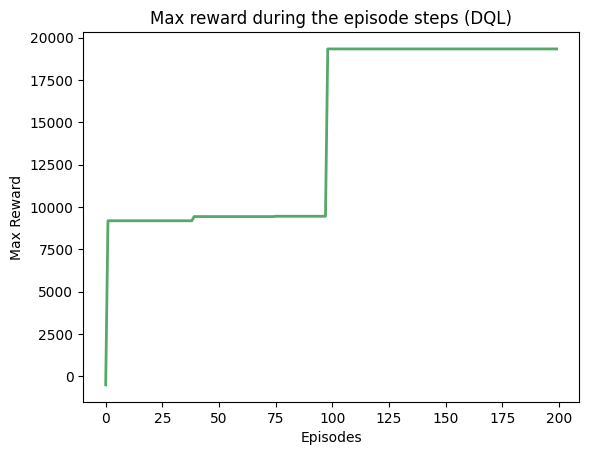

In [109]:
plt.plot(range(len(max_reward)),max_reward,'g-', linewidth=2, markersize=12)
plt.title('Max reward during the episode steps (DQL)')
plt.xlabel("Episodes")
plt.ylabel("Max Reward")

Text(0, 0.5, 'max Reward')

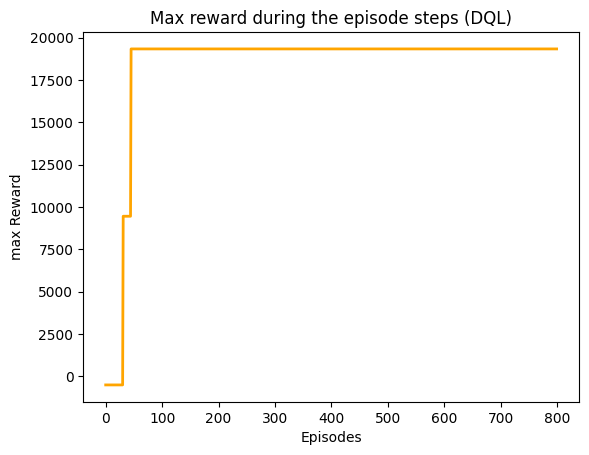

In [114]:
plt.plot(range(len(max_reward)),max_reward,color='orange', linewidth=2, markersize=12)
plt.title('Max reward during the episode steps (DQL)')
plt.xlabel("Episodes")
plt.ylabel("max Reward")

In [112]:
max_reward[799]

19342.0

In [ ]:
!pip install gym
import gym
#import gym_pathfinding
from time import sleep
env = gym.make('pathfinding-obstacle-v0')